In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torch_geometric.datasets import TUDataset
import torch
import torch.nn as nn
from torch_geometric.nn import Sequential, aggr, TransformerConv, norm
import pandas as pd
import matplotlib.pyplot as plt

from backend import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/michaln/Michal_Linux/git/envs/GNN_demo/lib/python3.13/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/michaln/Michal_Linux/git/envs/GNN_demo/lib/python3.13/site-packages/torch_scatter/_version_cpu.so: undefined symbol: __cxa_call_terminate
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


In [4]:
dataset = TUDataset(root='/tmp/TWITTER-Real-Graph-Partial', name='TWITTER-Real-Graph-Partial')#, use_node_attr=True)

In [5]:
train_loader, valid_loader, test_loader = get_dataloaders(dataset, batch_size=64, train_frac=0.8, test_frac=0.5)

Train: 115226
Valid: 14404
Test: 14403


In [7]:
class GraphTransformer(nn.Module):
    def __init__(self, num_features, num_classes, n_heads=5, k_h=64, p=0.3):
        super().__init__()
        
        self.encoder = Sequential(
            'x', [
                (nn.Linear(num_features, 500), 'x -> x'),
                norm.BatchNorm(500),
                nn.ReLU(inplace=True),
                nn.Dropout(p),
                nn.Linear(500, 250),
                norm.BatchNorm(250),
                nn.ReLU(inplace=True),
                nn.Dropout(p),
                nn.Linear(250, 100),
                norm.BatchNorm(100),
                nn.ReLU(inplace=True),
                nn.Dropout(p),
            ])

        d_h = k_h*n_heads
        self.transformer = Sequential(
            'x, edge_index, batch', [
            (TransformerConv(100, int(d_h/n_heads), heads=n_heads), 'x, edge_index -> x'),
            norm.BatchNorm(d_h),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
            (TransformerConv(d_h, int(d_h/n_heads), heads=n_heads), 'x, edge_index -> x'),
            norm.BatchNorm(d_h),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
            (TransformerConv(d_h, int(d_h/n_heads), heads=n_heads), 'x, edge_index -> x'),
            norm.BatchNorm(d_h),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
            (TransformerConv(d_h, int(d_h/n_heads), heads=n_heads), 'x, edge_index -> x'),
            norm.BatchNorm(d_h),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
            (aggr.MaxAggregation(), 'x, batch -> x'),
            nn.Linear(d_h, num_classes),
            ])
            
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.encoder(x)
        return self.transformer(x, edge_index, batch)

In [9]:
model = GraphTransformer(dataset.num_node_features, dataset.num_classes)

optim = torch.optim.Adam
optim_kwargs = {'lr': 1e-3, 'weight_decay': 1e-5}

model_module = GNNClassificationModule(model, (train_loader, valid_loader, test_loader), dataset.num_classes, optim, **optim_kwargs)#, lr=1e-3, weight_decay=1e-5)

outpath = 'GT_Twitter'

# Define checkpoint callback function to save best model
checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath=f"{outpath}/checkpoints/",
        save_top_k=1,        # Save the best model
        mode="min",
        every_n_epochs=1
    )

# Train and test the model
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  
    max_epochs=10,
    callbacks=[TQDMProgressBar(refresh_rate=20), checkpoint_callback],
    logger=CSVLogger(save_dir=f"{outpath}/logs/"),
)

trainer.fit(model_module)
trainer.test()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/michaln/Michal_Linux/git/envs/GNN_demo/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /home/michaln/Michal_Linux/git/GNN_demo/GT_Twitter/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | val_acc   | MulticlassAccuracy | 0      | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | test_acc  | Multicla

Sanity Checking: |                                                                                            …

/home/michaln/Michal_Linux/git/envs/GNN_demo/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/michaln/Michal_Linux/git/envs/GNN_demo/lib/python3.13/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/michaln/Michal_Linux/git/envs/GNN_demo/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

/home/michaln/Michal_Linux/git/envs/GNN_demo/lib/python3.13/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.
/home/michaln/Michal_Linux/git/envs/GNN_demo/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/michaln/Michal_Linux/git/GNN_demo/GT_Twitter/checkpoints/epoch=6-step=12607.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/michaln/Michal_Linux/git/GNN_demo/GT_Twitter/checkpoints/epoch=6-step=12607.ckpt
/home/michaln/Michal_Linux/git/envs/GNN_demo/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 

Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6520863771438599
        test_loss           0.6208643317222595
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6208643317222595, 'test_acc': 0.6520863771438599}]

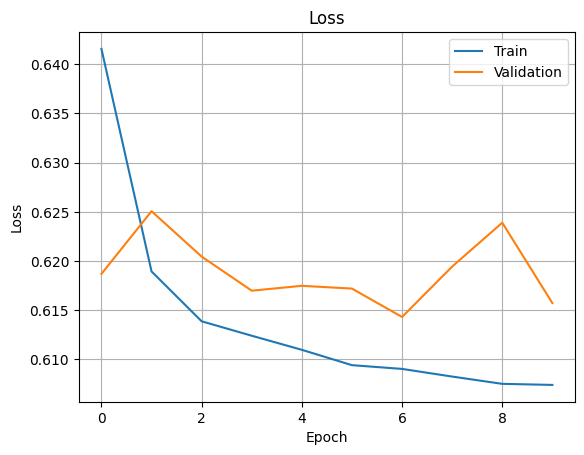

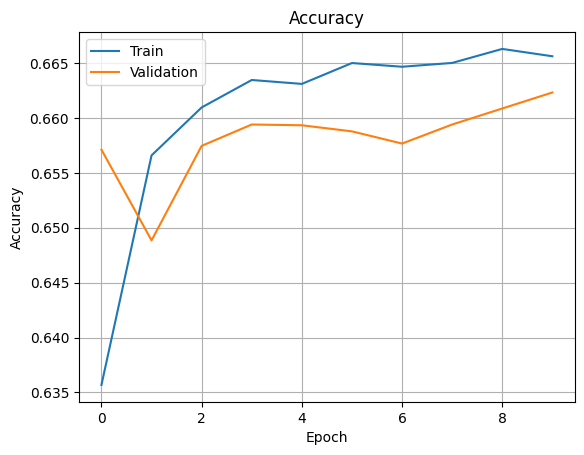

In [10]:
# Plot loss & accuracy
metrics_task = pd.read_csv(trainer.logger.log_dir + "/metrics.csv")
metrics_task.set_index("epoch", inplace=True)
metrics_task = metrics_task.groupby(level=0).sum().drop("step", axis=1)

plt.plot(metrics_task.train_loss[:-1], label='Train')
plt.plot(metrics_task.val_loss[:-1], label='Validation')
plt.title('Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

plt.show()

plt.plot(metrics_task.train_acc[:-1], label='Train')
plt.plot(metrics_task.val_acc[:-1], label='Validation')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

plt.show()